# "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.


## 1. To use already trained model, Importing the model and its supporting files for the model to function.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set files_zip_path to the location in the drive where you have the new `'Files_required_for_face_detection.zip'` file. This block will extract all the files to the current working directory. You should be seeing the list of all files inside the zip files as the output of this block after the final `!ls` command is executed. 

In [2]:
files_zip_path = "/content/drive/My Drive/Files_required_for_face_detection.zip"

import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(files_zip_path, 'r')
archive.extractall()
!ls

drive  Files_required_for_face_detection  sample_data


In [3]:
cd Files_required_for_face_detection

/content/Files_required_for_face_detection


In [4]:
#listing the files
!ls

dataset				__pycache__
face_generator.py		ssd_box_encode_decode_utils.py
keras_layer_AnchorBoxes.py	ssd_mobilenet_face_epoch_25_loss0.0916.h5
keras_layer_L2Normalization.py	wider_extract.py
keras_ssd_loss.py		wider_train_small.npy
mn_model.py			wider_train_v1.npy
mobilenet_1_0_224_tf.h5		wider_val_small.npy
predictor.py			wider_val_v1.npy


### Import MobileNet model given in file `mn_model.py`

In [5]:
### Import MobileNet model given in file `mn_model.py`
#Make sure you have the files required for face detection in the same folder as the code. If using Google Colabs upload
# them in the files section in the left panel 
from mn_model import mn_model

Using TensorFlow backend.


### Import the BatchGenerator and SSDLoss functions in given files `face_generator.py`, `keras_ssd_loss` and `ssd_box_encode_decode_utils.py` as well, used in MobileNet model

In [0]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model
# !pip install bs4 # use this if bs4 is not installed

import warnings
warnings.filterwarnings("ignore")

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

In [0]:
from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored

from mn_model import mn_model
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

# training parameters
from keras import backend as K
import scipy.misc as sm


## 2. Set the parameters for the model




In [0]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

#Path where you want to save the weights, model and checkpoints
det_model_path = "./"

## 3. Import the dataset for the model to train on (Wider Face dataset)

In [0]:
project_path = "/content/drive/My Drive/WiderFace/"

In [0]:
train_images_path = project_path + 'WIDER_train.zip'
test_images_path = project_path + 'WIDER_val.zip'

In [0]:
import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(train_images_path, 'r')
archive.extractall()

In [0]:
archive = zipfile.ZipFile(test_images_path, 'r')
archive.extractall()

## 4. Getting the Labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 

In [0]:
data = np.load('wider_train_small.npy').item()

In [14]:
### Printed first element to check the above given information.
# data contains lot of keys
for key in data:
    print (key)
    print (data[key])
    #Breaking after printing first key and its value
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


 As we can see from the above output all the information mentioned above is there for all the images.

### Now, load the files `wider_trian.npy` and `wider_val.npy`

In [0]:
train_data = 'wider_train_small.npy'
test_data = 'wider_val_small.npy'

x = np.load(train_data)

## 5. Making the model ready for training freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [16]:
# build the keras model
# this model is not pre-trained, we are doing it from scratch 

#K.clear_session()
#The following function returns you multiple things. The "model" is the Keras model that has to be trained 
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

====> Model Specific data
====> Height, Width, Channels : 512 512 3








#### Freezing all the layers in the above model with names not having ''`detection`'' word as prefix. 

In [17]:
#Freezing layers in the model which don't have 'detection' in their name
for layer in model.layers:
  if('detection' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False
#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

input_1
False
lambda1
False
lambda2
False
lambda3
False
conv1
False
conv1_bn
False
conv1_relu
False
conv_dw_1
False
conv_dw_1_bn
False
conv_dw_1_relu
False
conv_pw_1
False
conv_pw_1_bn
False
conv_pw_1_relu
False
conv_dw_2
False
conv_dw_2_bn
False
conv_dw_2_relu
False
conv_pw_2
False
conv_pw_2_bn
False
conv_pw_2_relu
False
conv_dw_3
False
conv_dw_3_bn
False
conv_dw_3_relu
False
conv_pw_3
False
conv_pw_3_bn
False
conv_pw_3_relu
False
conv_dw_4
False
conv_dw_4_bn
False
conv_dw_4_relu
False
conv_pw_4
False
conv_pw_4_bn
False
conv_pw_4_relu
False
conv_dw_5
False
conv_dw_5_bn
False
conv_dw_5_relu
False
conv_pw_5
False
conv_pw_5_bn
False
conv_pw_5_relu
False
conv_dw_6
False
conv_dw_6_bn
False
conv_dw_6_relu
False
conv_pw_6
False
conv_pw_6_bn
False
conv_pw_6_relu
False
conv_dw_7
False
conv_dw_7_bn
False
conv_dw_7_relu
False
conv_pw_7
False
conv_pw_7_bn
False
conv_pw_7_relu
False
conv_dw_8
False
conv_dw_8_bn
False
conv_dw_8_relu
False
conv_pw_8
False
conv_pw_8_bn
False
conv_pw_8_relu
False
conv

## 6. Loading the weights of the Mobile Net model

In [0]:
#loading the pre-trained weights of mobilenet
model.load_weights('mobilenet_1_0_224_tf.h5',by_name=True)

#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples. 

In [19]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


## 7. Setting the optimizers, loss functions(SSDLoss), epochs, learning rate, batch size, check pointing, early stopping etc. 

In [20]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 10

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [21]:
from math import ceil
steps_per_epoch = ceil(n_train_samples / batch_size)
#Print Summary
model.summary() 

# Patience for early stopping
PATIENCE = 50
# I have a 2 core computer without GPU
MULTI_PROCESSING = False 
# I have a 2 core computer without GPU
THREADS = 1 
# Checkpoint best validation model
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) 
# Stop early, if the validation error deteriorates
stop = EarlyStopping(monitor="val_loss", patience=PATIENCE, mode="max") 
# Reduce learning rate if Validation IOU does not improve
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda1 (Lambda)                (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda2 (Lambda)                (None, 512, 512, 3)  0           lambda1[0][0]                    
__________________________________________________________________________________________________
lambda3 (Lambda)                (None, 512, 512, 3)  0           lambda2[0][0]                    
__________________________________________________________________________________________________
conv1 (Con

## 8. Training the model

In [22]:
model.fit_generator(generator=train_generator,
                    validation_data=val_generator,
                    validation_steps=n_val_samples // batch_size,
                    epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[checkpoint,reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/10
8/8 [==============================] - 283s 35s/step - loss: 0.3484 - val_loss: 0.3946

Epoch 00001: val_loss improved from -inf to 0.39464, saving model to model-0.39.h5
Epoch 2/10
8/8 [==============================] - 246s 31s/step - loss: 0.2841 - val_loss: 0.3615

Epoch 00002: val_loss did not improve from 0.39464
Epoch 3/10
8/8 [==============================] - 246s 31s/step - loss: 0.2660 - val_loss: 0.3007

Epoch 00003: val_loss did not improve from 0.39464
Epoch 4/10
8/8 [==============================] - 244s 31s/step - loss: 0.2467 - val_loss: 0.3053

Epoch 00004: val_loss did not improve from 0.39464
Epoch 5/10
8/8 [==============================] - 247s 31s/step - loss: 0.2291 - val_loss: 0.2587

Epoch 00005: val_loss did not improve from 0.39464
Epoch 6/10
8/8 [==============================] - 240s 30s/step - loss: 0.2242 - val_loss: 0.2692

Epoch 00006: val_loss did not improve from 0.39464
Epoch 7/10
8/8 [==============================] - 239s 30s/step - lo

## 9. Loading the best saved weights

In [0]:
#Saving the model and weights. 
model.save('cnn_face_detection.h5')
model.save_weights('cnn_face_detecton_weights.h5')

## 10. Predicting using test images

### Plotting the boundingbox in the test image to show the predictions.

In [0]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, len(results))).tolist()
  color_code = len(results)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()


#### Getting the predictions for the test images using model.predict()

In [0]:
!mkdir output_test

In [26]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

test_size = 16
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for j in range(test_size):
  X, y, filenames = next(test_generator)
  num_files = len(filenames)

  y_pred = model.predict(X)


  y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


  np.set_printoptions(suppress=True)
  
  for i in range(num_files):
    save_bb("./output_test/", filenames[i], y_pred_decoded[i])
    save_bb("./output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
total number of bbs: 0
saved ./output_test/39_Ice_Skating_Ice_Skating_39_270.jpg
total number of bbs: 1
saved ./output_test/39_Ice_Skating_Ice_Skating_39_270_gt.jpg
total number of bbs: 2
saved ./output_test/58_Hockey_icehockey_puck_58_285.jpg
total number of bbs: 7
saved ./output_test/58_Hockey_icehockey_puck_58_285_gt.jpg
total number of bbs: 3
saved ./output_test/30_Surgeons_Surgeons_30_554.jpg
total number of bbs: 6
saved ./output_test/30_Surgeons_Surgeons_30_554_gt.jpg
total number of bbs: 3
saved ./output_test/4_Dancing_Dancing_4_514.jpg
total number of bbs: 2
saved ./output_test/4_Dancing_Dancing_4_514_gt.jpg
total number of bbs: 1
saved ./output_test/2_Demonstration_Demonstration_Or_Protest_2_306.jpg
total number of bbs: 10
saved ./output_test/2_Demonstration_Demonstration_Or_Protest_2_306_gt.jpg
total number of bbs: 2
saved ./output_test/16_Award_Ceremony_Awards_Ceremony_16_338.jpg
total number of bbs: 1
saved ./output_test/16_Award_Ceremony_Awards_Cere

In the above step all the test images along with predictions are stored in output_test folder in this notebook environment. You can check the folder in Files section of the menu to left-side of screen in colab.

Each test image is used for predictions and is stored as 2 files.

one file is the original ground truth with <filename_gt.jpg>
second file is the prediction of the model on the image. with <filename.jpg>

## Visualizing a test image to check predictions

In [0]:
# TESTING
import cv2
import numpy as np
from keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline


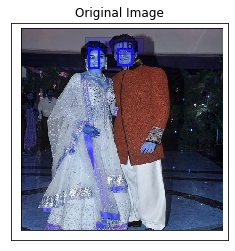

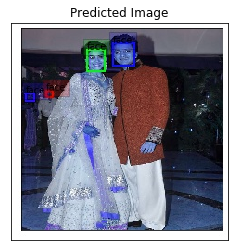

In [55]:
# Image 1
#Original Image
path='/content/Files_required_for_face_detection/output_test/17_Ceremony_Ceremony_17_1048.jpg'
img = cv2.imread(path,1)
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('Original Image')
plt.show()
#Predicted Image
path='/content/Files_required_for_face_detection/output_test/17_Ceremony_Ceremony_17_1048_gt.jpg'
img = cv2.imread(path,1)
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('Predicted Image')
plt.show()

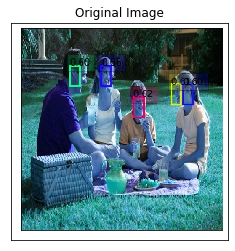

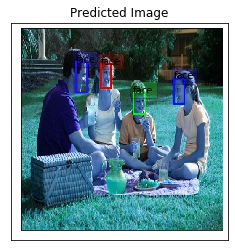

In [56]:
# Image 2
#Original Image
path='/content/Files_required_for_face_detection/output_test/22_Picnic_Picnic_22_10.jpg'
img = cv2.imread(path,1)
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('Original Image')
plt.show()
#Predicted Image
path='/content/Files_required_for_face_detection/output_test/22_Picnic_Picnic_22_10_gt.jpg'
img = cv2.imread(path,1)
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('Predicted Image')
plt.show()

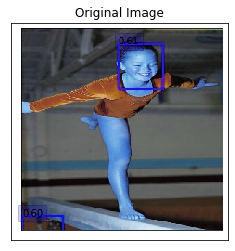

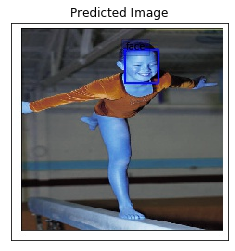

In [60]:
# Image 3
#Original Image
path='/content/Files_required_for_face_detection/output_test/40_Gymnastics_Gymnastics_40_57.jpg'
img = cv2.imread(path,1)
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('Original Image')
plt.show()
#Predicted Image
path='/content/Files_required_for_face_detection/output_test/40_Gymnastics_Gymnastics_40_57_gt.jpg'
img = cv2.imread(path,1)
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.title('Predicted Image')
plt.show()

## Insights
1. The testing on dataset clearly shows that the model is correctly predicting the face on an image.
2. We can go on further to recognize the face and give label to them.